In [1]:
# Import libraries

import tensorflow as tf
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from PIL import Image

In [2]:
# Set random seed for reproducibility
# tf.random.set_seed(42)

In [3]:
# Define the custom preprocessing function to crop images to a square ratio

# Crop a square from the center of the image
def crop_to_square_for_img(image):
    width, height = image.size
    new_width = new_height = min(width, height)
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    # Crop the image file
    image = image.crop((left, top, right, bottom))
    
    return image

def crop_to_square_for_arr(image):
    width, height = image.shape[1], image.shape[0]
    new_width = new_height = min(width, height)
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    # Crop the array by selecting a subset of rows and columns
    image = image[int(top):int(bottom), int(left):int(right)]
    return image

In [4]:
data_dir = 'data'
image_size = (178, 218)

In [5]:
# Get the list of files and labels
file_paths = []
labels = []

for class_label in os.listdir(data_dir):
    # Skip if file is not a directory
    if not os.path.isdir(os.path.join(data_dir, class_label)):
        continue
    class_path = os.path.join(data_dir, class_label)
    
    # Add only jpg files
    class_files = [os.path.join(class_path, file) for file in os.listdir(class_path) if file.lower().endswith('.jpg')]
    
    # Set label based on class
    # if class_label == 'wearing_hat':
    #     class_label = 1
    # elif class_label == 'not_wearing_hat':
    #     class_label = 0
    # else:
    #     # Handle other classes if needed
    #     continue
    
    file_paths.extend(class_files)
    labels.extend([class_label] * len(class_files))

In [6]:
print(len(file_paths), len(labels))

1900 1900


In [7]:
print(labels[0:5])

['wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat']


In [8]:
# Split the data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2)
# train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25)

In [9]:
print(len(train_paths), len(train_labels))
#print(len(val_paths), len(val_labels))

1520 1520


In [10]:
print(train_paths[0:5])
print(train_labels[0:5])

['data/not_wearing_hat/082417.jpg', 'data/not_wearing_hat/120132.jpg', 'data/wearing_hat/075003.jpg', 'data/not_wearing_hat/176031.jpg', 'data/wearing_hat/178164.jpg']
['not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat']


In [11]:
# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=crop_to_square_for_arr)
val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=crop_to_square_for_arr)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=crop_to_square_for_arr)

# Define batch size
batch_size = 32

In [12]:
print(type(pd.DataFrame({'filename': train_paths, 'class': train_labels})['filename']))

<class 'pandas.core.series.Series'>


In [13]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(pd.DataFrame({'filename': train_paths, 'class': train_labels}), 
                                                    target_size=(178, 178),
                                                    batch_size=batch_size, 
                                                    class_mode='binary'
                                                    )

Found 1520 validated image filenames belonging to 2 classes.


In [14]:
print(train_generator.filenames)

['data/not_wearing_hat/082417.jpg', 'data/not_wearing_hat/120132.jpg', 'data/wearing_hat/075003.jpg', 'data/not_wearing_hat/176031.jpg', 'data/wearing_hat/178164.jpg', 'data/not_wearing_hat/127350.jpg', 'data/wearing_hat/091871.jpg', 'data/wearing_hat/169890.jpg', 'data/wearing_hat/157597.jpg', 'data/not_wearing_hat/139299.jpg', 'data/not_wearing_hat/175313.jpg', 'data/not_wearing_hat/133468.jpg', 'data/wearing_hat/102152.jpg', 'data/not_wearing_hat/162005.jpg', 'data/wearing_hat/114498.jpg', 'data/not_wearing_hat/126789.jpg', 'data/not_wearing_hat/183801.jpg', 'data/not_wearing_hat/094551.jpg', 'data/not_wearing_hat/173883.jpg', 'data/not_wearing_hat/025657.jpg', 'data/not_wearing_hat/067428.jpg', 'data/wearing_hat/075895.jpg', 'data/not_wearing_hat/180679.jpg', 'data/not_wearing_hat/180415.jpg', 'data/not_wearing_hat/008479.jpg', 'data/not_wearing_hat/119287.jpg', 'data/wearing_hat/193260.jpg', 'data/not_wearing_hat/038626.jpg', 'data/wearing_hat/069846.jpg', 'data/not_wearing_hat/15

In [15]:

# Define the CNN architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(178, 178, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

2023-09-30 23:38:57.619875: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-09-30 23:38:57.619906: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-30 23:38:57.619914: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-30 23:38:57.620042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-30 23:38:57.620063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 176, 176, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 88, 88, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 86, 86, 64)        2

In [16]:
# Perform k-fold cross validation
k = 5

# Load images from file paths
X = np.array([np.array(crop_to_square_for_img(Image.open(path))) for path in train_paths])

# Convert labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_labels)

# Normalize pixel values to be between 0 and 1
X = X / 255.0

# Initialize KFold
kf = KFold(n_splits=k, shuffle=True)

# Placeholder to store validation accuracies
validation_accuracies = []

# Iterate through each fold
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}:")

    # Split data into train and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model on the validation set
    val_predictions = np.argmax(model.predict(X_val), axis=1)
    val_accuracy = accuracy_score(y_val, val_predictions)
    print("Validation Accuracy:", val_accuracy)
    validation_accuracies.append(val_accuracy)

# Print average validation accuracy across all folds
print("\nAverage Validation Accuracy:", np.mean(validation_accuracies))



Fold 1:
Epoch 1/10


2023-09-30 23:39:03.336806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8684

2023-09-30 23:39:15.555719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 16s 161ms/step - loss: 0.4194 - accuracy: 0.8684 - val_loss: 1.0647 - val_accuracy: 0.5691
Epoch 2/10
38/38 [==============================] - 3s 77ms/step - loss: 0.1984 - accuracy: 0.9219 - val_loss: 0.5869 - val_accuracy: 0.5954
Epoch 3/10
38/38 [==============================] - 3s 72ms/step - loss: 0.1495 - accuracy: 0.9383 - val_loss: 0.4880 - val_accuracy: 0.8125
Epoch 4/10
38/38 [==============================] - 3s 81ms/step - loss: 0.1341 - accuracy: 0.9457 - val_loss: 0.5537 - val_accuracy: 0.7039
Epoch 5/10
38/38 [==============================] - 3s 74ms/step - loss: 0.1164 - accuracy: 0.9564 - val_loss: 0.4878 - val_accuracy: 0.7763
Epoch 6/10
38/38 [==============================] - 3s 69ms/step - loss: 0.0930 - accuracy: 0.9712 - val_loss: 0.4999 - val_accuracy: 0.7171
Epoch 7/10
38/38 [==============================] - 3s 71ms/step - loss: 0.0817 - accuracy: 0.9704 - val_loss: 0.8833 - val_accuracy: 0.5132
Epoch 8/10
38/38 [====

2023-09-30 23:39:43.599158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 56ms/step
Validation Accuracy: 0.569078947368421

Fold 2:
Epoch 1/10
38/38 [==============================] - 4s 85ms/step - loss: 0.0516 - accuracy: 0.9827 - val_loss: 0.1880 - val_accuracy: 0.9112
Epoch 2/10
38/38 [==============================] - 3s 75ms/step - loss: 0.0662 - accuracy: 0.9745 - val_loss: 0.1258 - val_accuracy: 0.9441
Epoch 3/10
38/38 [==============================] - 3s 76ms/step - loss: 0.0522 - accuracy: 0.9778 - val_loss: 0.1436 - val_accuracy: 0.9408
Epoch 4/10
38/38 [==============================] - 3s 69ms/step - loss: 0.0415 - accuracy: 0.9852 - val_loss: 0.0679 - val_accuracy: 0.9836
Epoch 5/10
38/38 [==============================] - 3s 72ms/step - loss: 0.0312 - accuracy: 0.9893 - val_loss: 0.0745 - val_accuracy: 0.9704
Epoch 6/10
38/38 [==============================] - 3s 73ms/step - loss: 0.0407 - accuracy: 0.9860 - val_loss: 0.1164 - val_accuracy: 0.9507
Epoch 7/10
38/38 [==============================] - 

In [17]:

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

NameError: name 'val_generator' is not defined

In [18]:

true_labels = test_labels
print(true_labels)

['wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_

In [19]:
# if true_labels == 'wearing_hat' then change it to 1
true_label_ints = [1 if x == 'wearing_hat' else 0 for x in true_labels]

print(true_label_ints)


[1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 

In [20]:
test_generator = test_datagen.flow_from_dataframe(pd.DataFrame({'filename': test_paths, 'class': test_labels}), 
                                                  target_size=(178, 178),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='binary'
                                                 )

Found 380 validated image filenames belonging to 2 classes.


In [21]:
test_generator.classes = true_label_ints
print(test_generator.classes)
print(test_generator.filenames)

[1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 

In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f'Test Accuracy: {test_accuracy}')

2023-09-30 23:42:14.464762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 - 3s - loss: 0.2881 - accuracy: 0.9237 - 3s/epoch - 239ms/step
Test Accuracy: 0.9236842393875122


In [23]:
# Make predictions
predictions = model.predict(test_generator)
print(predictions)


2023-09-30 23:42:19.944406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 50ms/step
[[9.99999881e-01]
 [9.72282887e-01]
 [9.98552740e-01]
 [9.96557355e-01]
 [1.68264061e-02]
 [4.23103046e-07]
 [9.99967813e-01]
 [9.96493280e-01]
 [9.99445736e-01]
 [9.99996901e-01]
 [4.74544329e-04]
 [1.00000000e+00]
 [9.99979377e-01]
 [9.99997735e-01]
 [4.68433382e-06]
 [5.19292895e-03]
 [3.87383479e-05]
 [9.99988675e-01]
 [5.80808401e-01]
 [1.00000000e+00]
 [3.35640460e-03]
 [5.04528033e-03]
 [9.98543262e-01]
 [1.00000000e+00]
 [9.49542373e-02]
 [4.83826370e-05]
 [3.38871941e-05]
 [9.99723971e-01]
 [9.99999881e-01]
 [7.55629981e-06]
 [9.99999881e-01]
 [4.30253152e-07]
 [1.99960242e-03]
 [9.99999881e-01]
 [9.99645591e-01]
 [6.57501593e-02]
 [6.31026996e-05]
 [7.26398430e-05]
 [9.99936819e-01]
 [2.47066584e-03]
 [5.60129946e-03]
 [2.08313839e-04]
 [1.50136169e-04]
 [9.99999881e-01]
 [9.34082735e-03]
 [1.36862576e-01]
 [1.42405785e-04]
 [8.23305130e-01]
 [9.98945892e-01]
 [9.81846035e-01]
 [9.99993801e-01]
 [9.99999881e-01]
 [6.003162

In [24]:
predicted_labels = np.round(predictions).flatten()  # Assuming a sigmoid activation in the output layer

In [25]:
print(true_labels)

['wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_

In [26]:
print(predicted_labels)

[1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.

In [27]:
predicted_labels = ['wearing_hat' if x == 1 else 'not_wearing_hat' for x in predicted_labels]

print(predicted_labels)

['wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat', 'wearing_hat', 'not_wearing_hat'

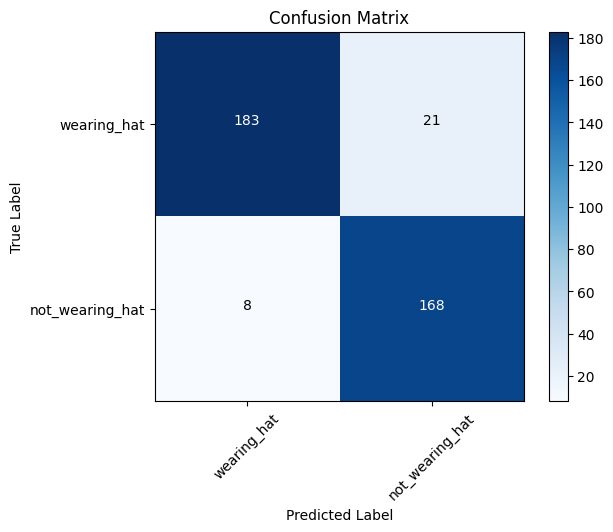

                 precision    recall  f1-score   support

not_wearing_hat       0.96      0.90      0.93       204
    wearing_hat       0.89      0.95      0.92       176

       accuracy                           0.92       380
      macro avg       0.92      0.93      0.92       380
   weighted avg       0.93      0.92      0.92       380



In [28]:
# Plot Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
# Define the class labels
class_labels = ["wearing_hat", "not_wearing_hat"]

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

thresh = cm.max() / 2.

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

# Set custom axis labels
tick_marks = range(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels))

In [29]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f'Test Accuracy: {test_accuracy}')


12/12 - 1s - loss: 0.2881 - accuracy: 0.9237 - 648ms/epoch - 54ms/step
Test Accuracy: 0.9236842393875122


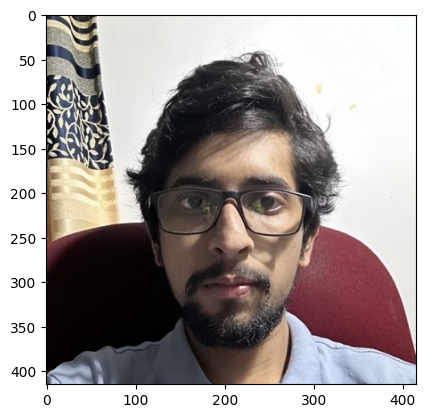

In [30]:
# Predict on a single image
# Load the image and resize it to the target size of 178 x 178 also crop it to a square
image = tf.keras.preprocessing.image.load_img('real_world/nocap-sr-1.jpeg')
image = crop_to_square_for_img(image)

# Show the image using matplotlib
plt.imshow(image)

In [31]:

# Resize the image to the target size of 178 x 178
image = image.resize((178, 178))

# Convert the image to a numpy array
input_arr = tf.keras.preprocessing.image.img_to_array(image)

# Add another dimension (since Keras expects a list of images)
input_arr = np.array([input_arr])

# Make predictions
predictions = model.predict(input_arr)
print(predictions)

if predictions[0][0] == 1:
    print('The person is wearing a hat')
else:
    print('The person is not wearing a hat')

1/1 [==============================] - 1s 729ms/step
[[0.]]
The person is not wearing a hat
